In [1]:
from ast import literal_eval
from const_definitions import SolverEvents
from matplotlib import pyplot as plot
import numpy as np
import pandas as pd

ImportError: libLerc.so.4: cannot open shared object file: No such file or directory

In [ ]:
def parse_numpy_data(item):
    item_eval = literal_eval(item)
    if item_eval is None:
        return np.array([])
    return np.array(item_eval)


column_parse_dict = {col: parse_numpy_data for col in ["Y", "DYDT_EST"]}

# Local Optima Tracking: Simple Example

We're interested in the DAEO
$$
\begin{aligned}
    x(0) &= 1 \\
    x\prime(t) &= -(2+y(t))\cdot x(t)\\
    \left\{y(t)\right\} &= \argmin_y h(x,y)
\end{aligned}
$$
with
$$
h(x,y) = \left(1-y^2\right)^2-\left(x-\frac{1}{2}\right)\sin\frac{\pi}{2}y
$$

which has the analytical solution
$$
x(t) = \begin{cases} \exp -3t & t\in\left[0,-\frac{1}{3}\ln\frac{1}{2}\right]\\
    \exp \left(-t+\frac{2}{3}\ln\frac{1}{2}\right) & t\in\left[-\frac{1}{3}\ln\frac{1}{2},1\right]
    \end{cases}
$$


In [ ]:
t_event = -np.log(0.5)/3

In [ ]:
def x_exact(t):
    A = -2 * t_event
    return np.where(t<t_event, np.exp(-3*t), np.exp(-t + A))

In [ ]:
def l1_norm(data, dt):
    return 0.5 * np.dot(np.abs(data[0:-1]) + np.abs(data[1:]), dt)

In [ ]:
def solution_indices(df: pd.DataFrame):
    indices = ((df["EVENTID"] == SolverEvents.TIME_STEP_NO_EVENT) |
               (df["EVENTID"] == SolverEvents.TIME_STEP_EVENT_CORRECTED) | 
               (df["EVENTID"] == SolverEvents.SOLVER_BEGIN))
               # (df["EVENTID"] == SolverEvents.SOLVER_COMPLETE))
    return indices

def error_series(solution_log: pd.DataFrame):
    err = solution_log["X"] - x_exact(solution_log["T"])
    return err

In [ ]:
def simple_convergence_data(dir: str, log_name_format: str, h_min_pow: int):
    te_exact = -1 / 3 * np.log(0.5)
    dt = np.zeros(h_min_pow)
    l2_error_norm = np.zeros(h_min_pow)
    t_e_error = np.zeros(h_min_pow)
    for i in range(h_min_pow):
        solver_log = pd.read_csv(
            f"{dir}/{log_name_format.format(i)}",
            sep="\t",
            header=0,
            converters=column_parse_dict)
        solution_log = solver_log[solution_indices]
        dt[i] = np.power(10.0, -i)
        error = solution_log["X"] - x_exact(solution_log["T"])
        # l2 via right-riemann
        l2_error_norm[i] = l1_norm(error, solution_log["DT"].iloc[2:])
        event_correction = solution_log[solution_log.EVENTID ==
                                        SolverEvents.TIME_STEP_EVENT_CORRECTED]
        te_est = event_correction["T"]
        t_e_error[i] = np.abs(te_est.iloc[0] - te_exact) if te_est.shape[0] > 0 else 0.0
    return dt, l2_error_norm, t_e_error

In [ ]:
soln = pd.read_csv(
    "../data/out/simple_example_10_minus_4_solver_log.tsv",
    sep="\t",
    header=0,
    converters=column_parse_dict)[solution_indices]


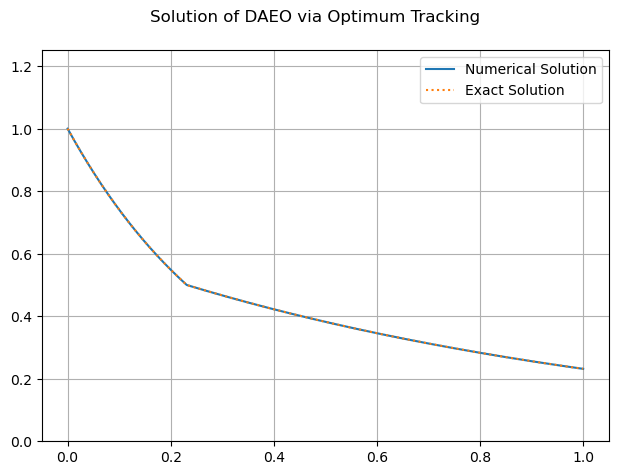

In [ ]:
fig, ax = plot.subplots()
fig.suptitle("Solution of DAEO via Optimum Tracking")
fig.tight_layout()
ax.plot(soln["T"], soln["X"], label="Numerical Solution")
ax.plot(soln["T"], x_exact(soln["T"]), label="Exact Solution", ls=":")
ax.legend()
ax.set_ylim((0,1.25))
ax.grid(True)

In [ ]:
dt_wevt, l2_err_wevt, evt_err = simple_convergence_data("../data/out","simple_example_10_minus_{:d}_solver_log.tsv",4)
dt_noevt, l2_err_noevt, evt_err_noevt = simple_convergence_data("../data/out","simple_example_10_minus_{:d}_noevents_solver_log.tsv",4)

In [ ]:
def daeo_convergence_plots(dt, l2_err, evt_err, fig, axs, plot_order=True):
    fig.tight_layout()
    for ax in axs:
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.grid(True)
        ax.set_xlabel("$\Delta t$")
        if plot_order:
            ax.plot(dt, 0.1*dt, label="$\mathcal{O}(\Delta t)$", ls=":")
            ax.plot(dt, 0.1*dt**2, label="$\mathcal{O}(\Delta t^2)$", ls=":")
        ax.legend()
    axs[0].scatter(dt, l2_err, marker="*")
    axs[0].set_title("L2-Norm Error of Solution")
    axs[1].scatter(dt, evt_err, marker="*")
    axs[1].set_title("Error in Event Location")
    return fig, axs


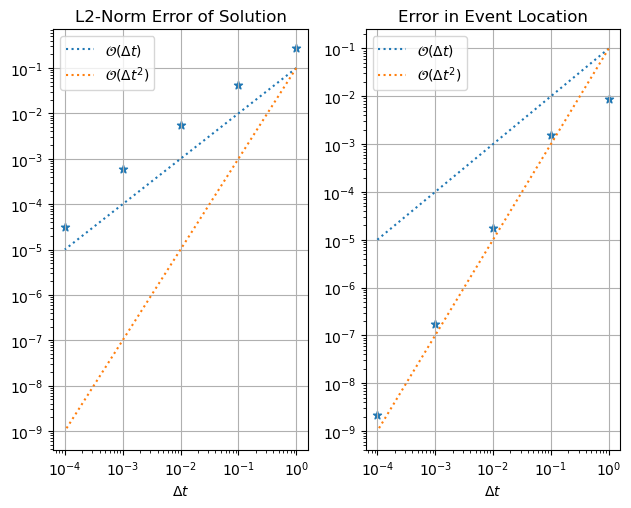

In [ ]:
fig, ax = daeo_convergence_plots(dt_wevt, l2_err_wevt, evt_err, *plot.subplots(1,2))

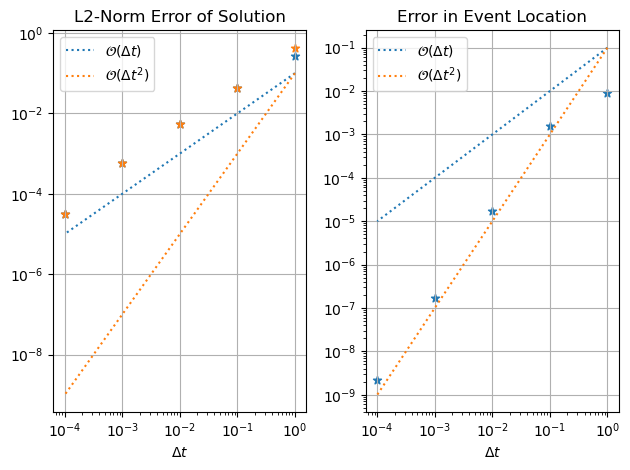

In [ ]:
f1, ax1 = daeo_convergence_plots(dt_noevt, l2_err_noevt, evt_err_noevt, fig, ax, plot_order=False)
f1